# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU.

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [1]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2025-10-06 01:39:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   153MB/s    in 0.4s    

2025-10-06 01:39:32 (153 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -qo cats_and_dogs_filtered.zip

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [3]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring.

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test.

In [4]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

# train_transforms = transforms.Compose([
#                                     transforms.Resize((256, 256)),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
#                                     transforms.RandomRotation(20),
#                                     transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
#                                     transforms.ToTensor(),  # convert PIL to Pytorch Tensor
#                                     normalize,
#                                 ])

# augmentation

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),                          # match val geometry
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(
        brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05
    )], p=0.3),                                             # mild, not always on
    transforms.RandomAffine(
        degrees=10, translate=(0.05, 0.05),
        scale=(0.95, 1.05), shear=5
    ),                                                      # light pose/scale changes
    transforms.RandomPerspective(distortion_scale=0.08, p=0.1),
    transforms.ToTensor(),
    normalize,
])


validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

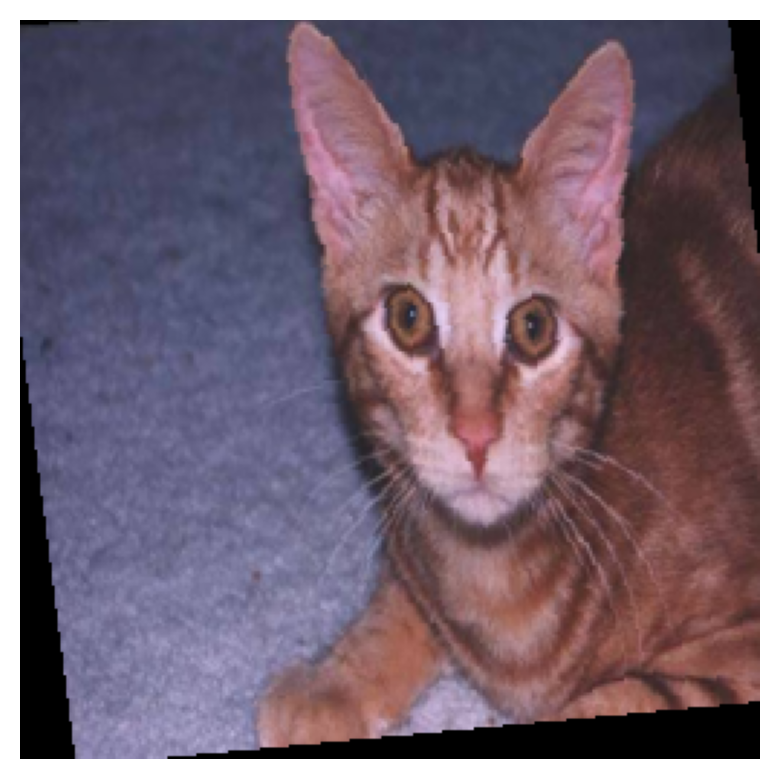

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(train_dataset[10][0])

### Creating the model

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [6]:
import torch
from torch import nn

def conv3x3(in_ch, out_ch, stride=1):
    # bias=True, 3x3, padding=1
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=True)

class BasicBlock(nn.Module):
    """
    ResNet Basic Block:
    conv3x3 -> BN -> ReLU(False) -> conv3x3 -> BN -> add(skip) -> ReLU(False)
    Projection skip (when needed) uses 3x3 (not 1x1), with stride and padding=1.
    """

    def __init__(self, in_ch, out_ch, stride=1, use_projection=False):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=False)
        self.conv2 = conv3x3(out_ch, out_ch, 1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        # use 3x3 projection with same stride, padding=1, bias=True
        if use_projection:
            self.proj = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=True),
                nn.BatchNorm2d(out_ch),
            )
        else:
            self.proj = nn.Identity()

    def forward(self, x):
        identity = self.proj(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

class CNN_Solution(nn.Module):
    """
    - Stem: Conv(7x7,bias=True) -> BN -> MaxPool (no ReLU before pool)
    - Stages: 2 BasicBlocks per stage; first block of stages 2–4 downsamples via stride=2
      and uses a 3x3 projection skip (not 1x1).
    - Final FC: Linear(512, 1)
    - No custom weight init (use PyTorch defaults like Code 1).
    """
    def __init__(self, in_channels=3):
        super().__init__()

        self.conv0 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=True)
        self.bn0   = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 topology (2 blocks per stage)
        self.layer1 = self._make_stage(64,   64,  blocks=2, stride=1)  # 56x56
        self.layer2 = self._make_stage(64,   128, blocks=2, stride=2)  # 28x28 (proj 3x3 s2)
        self.layer3 = self._make_stage(128,  256, blocks=2, stride=2)  # 14x14 (proj 3x3 s2)
        self.layer4 = self._make_stage(256,  512, blocks=2, stride=2)  # 7x7  (proj 3x3 s2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512, 1)

    def _make_stage(self, in_ch, out_ch, blocks, stride):
        layers = []
        # First block may downsample -> needs projection (3x3) if stride!=1 or channels change
        layers.append(BasicBlock(in_ch, out_ch, stride=stride,
                                 use_projection=(stride != 1 or in_ch != out_ch)))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_ch, out_ch, stride=1, use_projection=False))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem (conv->bn->maxpool) like Code 1
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.maxpool(x)

        # Stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [7]:
from tqdm.notebook import tqdm

def get_loss_and_correct(model, batch, criterion, device):
  # TODO
  # Implement forward pass and loss calculation for one batch.
  # Remember to move the batch to device.
  #
  # Return a tuple:
  # - loss for the batch (Tensor)
  # - number of correctly classified examples in the batch (Tensor)
  inputs, labels = batch
  inputs = inputs.to(device)
  # BCEWithLogitsLoss expects float targets of shape (N, 1)
  labels = labels.to(device).float().view(-1, 1)

  # forward (outputs are logits)
  logits = model(inputs)
  loss = criterion(logits, labels)

  # predictions: sigmoid(logits) >= 0.5  <=>  logits >= 0
  preds = (logits >= 0).long().view(-1)
  correct = (preds == labels.long().view(-1)).sum().item()

  return loss, correct

def step(loss, optimizer):
  # Implement backward pass and update.
  # TODO
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


N_EPOCHS = 5
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN_Solution()

criterion = torch.nn.BCEWithLogitsLoss() # TODO
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # TODO
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS) # cosine lr scheduler

model.train()

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = 0.0
  total_train_correct = 0.0
  total_validation_loss = 0.0
  total_validation_correct = 0.0

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct

  scheduler.step()  # scheduler step

  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
      loss, correct = get_loss_and_correct(model, batch, criterion, device)
      total_validation_loss += loss.item()
      total_validation_correct += correct

  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)

  mean_validation_loss = total_validation_loss / len(validation_dataset)
  validation_accuracy = total_validation_correct / len(validation_dataset)

  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)

  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)

  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

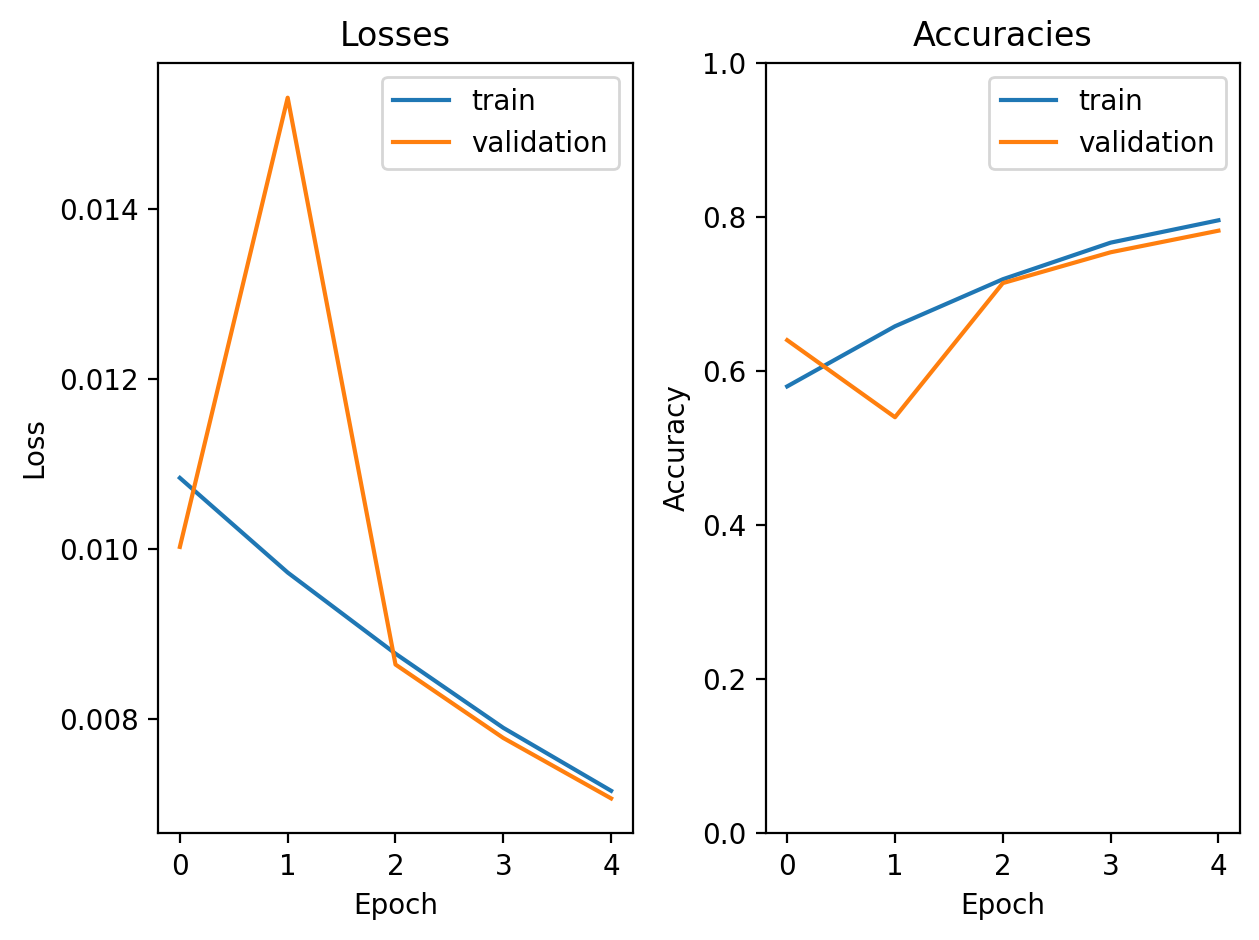

In [8]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

In [9]:
print(f'maximum validation accuracy: {max(validation_accuracies)}')

maximum validation accuracy: 0.782


Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations.

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
No overfitting here. After epoch 2, train and val losses both fall and the accuracies rise together with only a tiny gap, which means the model generalizes.
The early spike in validation loss (epoch 1) is typical: random init + BatchNorm stats still settling and a relatively higher LR at the start of the cosine schedule (plus stronger train aug) make validation bumpy for a bit. Once the optimizer cools and BN stabilizes, validation quickly improves and tracks training—no divergence, so no overfit within 5 epochs.

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

test_loss = 0.008450605154037475
test_acc  = 0.716


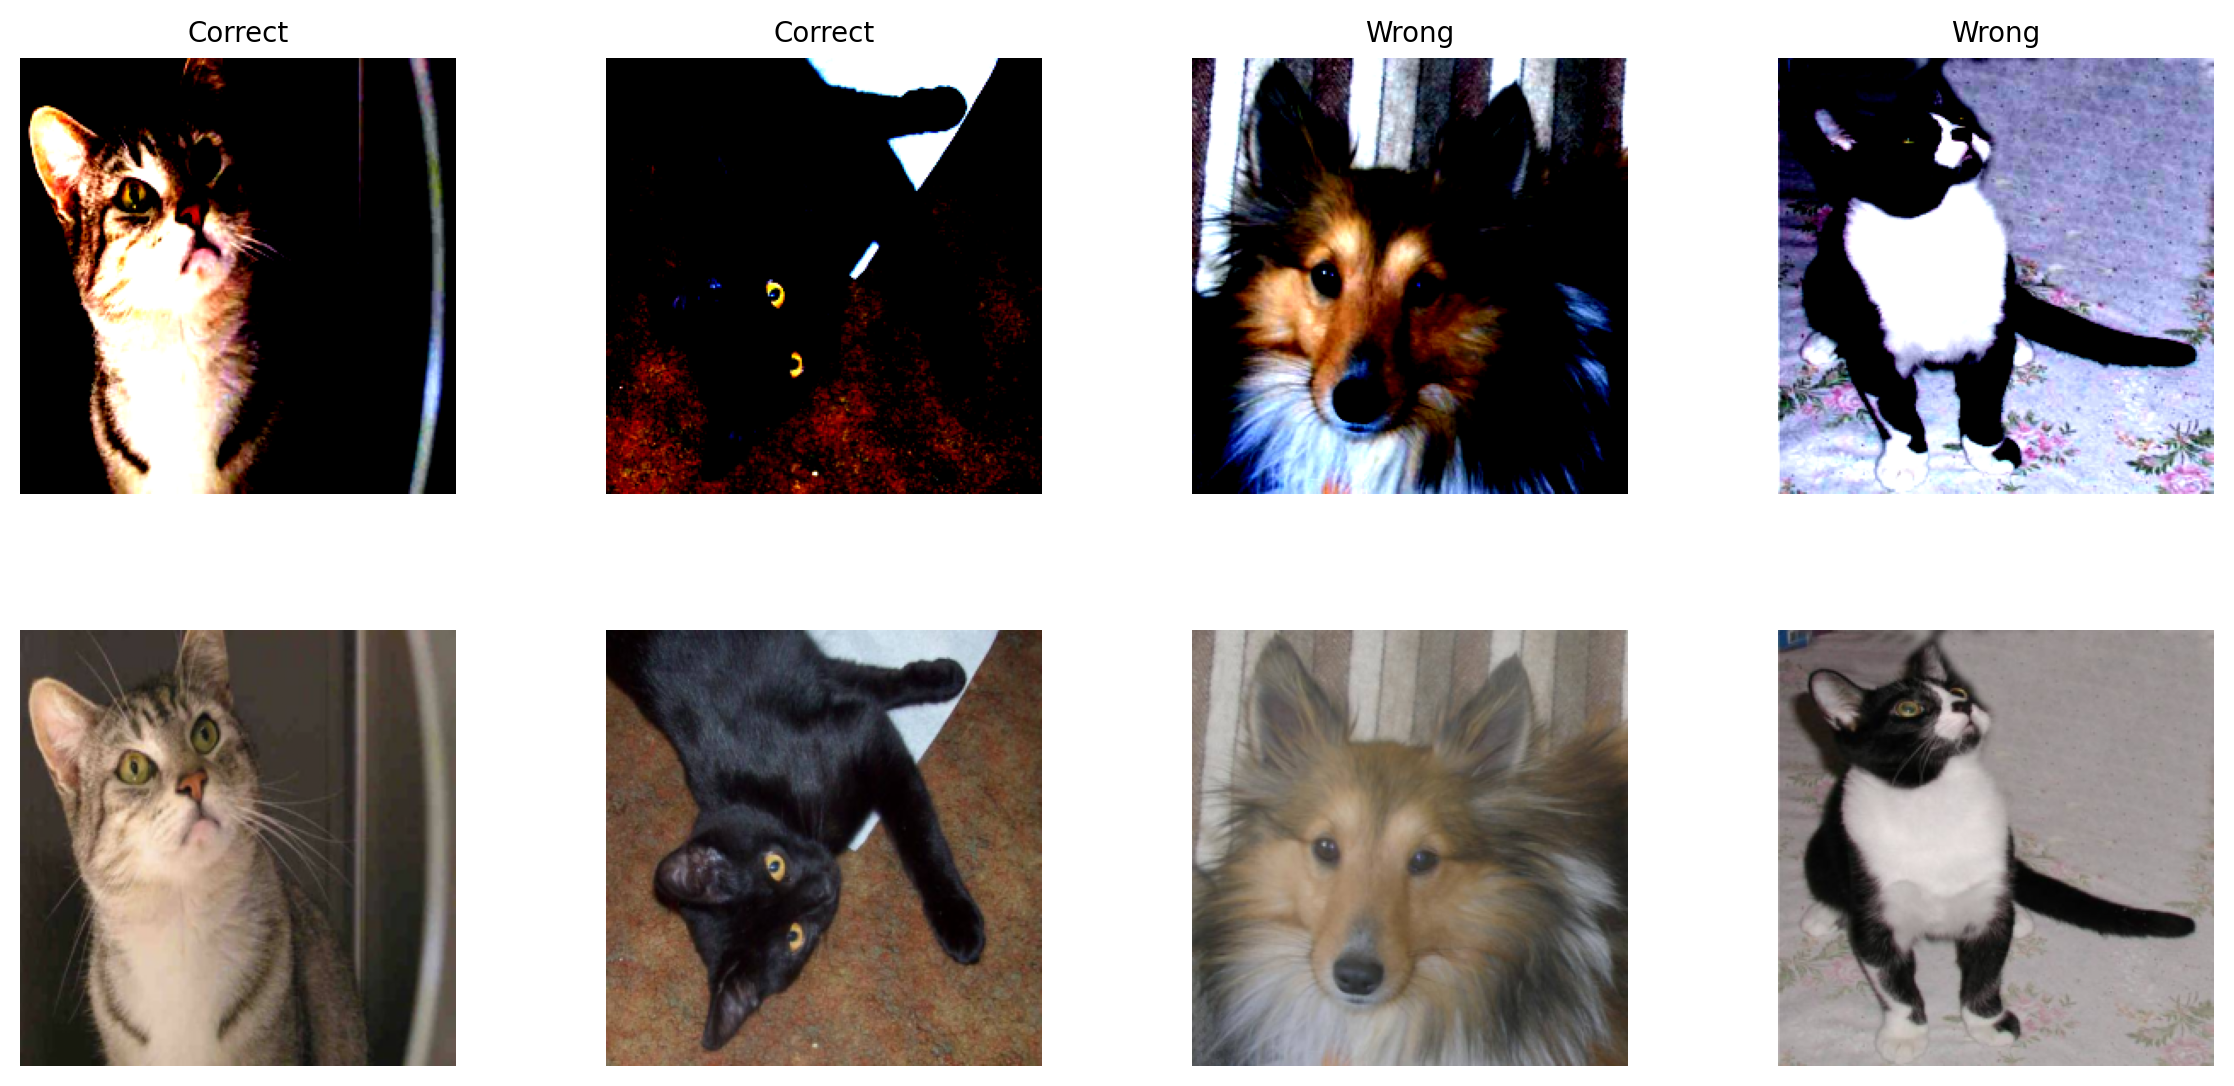

In [10]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.


import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------- TESTING ----------
def evaluate_test(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    num_correct = 0
    num_examples = len(loader.dataset)

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            targets = targets.to(device).float()   # keep float targets as in original

            logits = model(imgs).squeeze()        # (N,) after squeeze
            batch_loss = criterion(logits, targets)  # same reduction as your criterion
            total_loss += batch_loss.sum().item()    # match original .sum().item()

            preds = (logits > 0.5)                  # same decision rule as original
            num_correct += (preds == targets).sum().item()

    avg_loss = total_loss / num_examples
    acc = num_correct / num_examples
    return avg_loss, acc

# same loader semantics (shuffle=True) to avoid changing behavior
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)

test_loss, test_acc = evaluate_test(model, test_dataloader, criterion, device)
print("test_loss =", test_loss)
print("test_acc  =", test_acc)


# ---------- VISUALIZATION ----------
# Safe image helpers (avoid imshow clipping warnings)
def _to_disp(img_chw):
    """For the first row (normalized tensors), just clamp to [0,1] so imshow won't warn."""
    arr = img_chw.detach().cpu().permute(1, 2, 0).numpy()
    return np.clip(arr, 0.0, 1.0)

def _unnorm(img_chw, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Denormalize to RGB [0,1]. Edit mean/std if you used different stats."""
    x = img_chw.detach().cpu().clone()
    for c in range(x.shape[0]):
        x[c] = x[c] * std[c] + mean[c]
    arr = x.permute(1, 2, 0).numpy()
    return np.clip(arr, 0.0, 1.0)

def show_test_examples(model, batch, batch_size, n_each, device):
    """Show n_each correct and n_each incorrect predictions.
       Row 0: clamped normalized images; Row 1: denormalized for human viewing."""
    imgs, targets = batch
    imgs = imgs.to(device)
    targets = targets.to(device).float()

    with torch.no_grad():
        logits = model(imgs).squeeze()
        is_correct = (logits > 0.5) == targets

    # 2 rows, 2*n_each columns
    cols = n_each * 2
    fig, axes = plt.subplots(2, cols, figsize=(3*cols, 6))
    fig.tight_layout(pad=2.0)

    placed = 0
    placed_correct = 0
    placed_wrong = 0

    for i in range(min(batch_size, imgs.size(0))):
        if is_correct[i] and placed_correct < n_each:
            col = placed_correct
            axes[0, col].imshow(_to_disp(imgs[i]))
            axes[0, col].set_title("Correct", fontsize=10)
            axes[0, col].axis("off")

            axes[1, col].imshow(_unnorm(imgs[i]))
            axes[1, col].axis("off")

            placed_correct += 1
        elif (not is_correct[i]) and placed_wrong < n_each:
            col = n_each + placed_wrong
            axes[0, col].imshow(_to_disp(imgs[i]))
            axes[0, col].set_title("Wrong", fontsize=10)
            axes[0, col].axis("off")

            axes[1, col].imshow(_unnorm(imgs[i]))
            axes[1, col].axis("off")

            placed_wrong += 1

        placed = placed_correct + placed_wrong
        if placed == 2 * n_each:
            break

    # hide any unused subplots
    for r in range(2):
        for c in range(placed, 2 * n_each):
            axes[r, c].axis("off")

    plt.show()

# example usage
test_batch = next(iter(test_dataloader))
show_test_examples(model, test_batch, BATCH_SIZE, n_each=2, device=device)

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

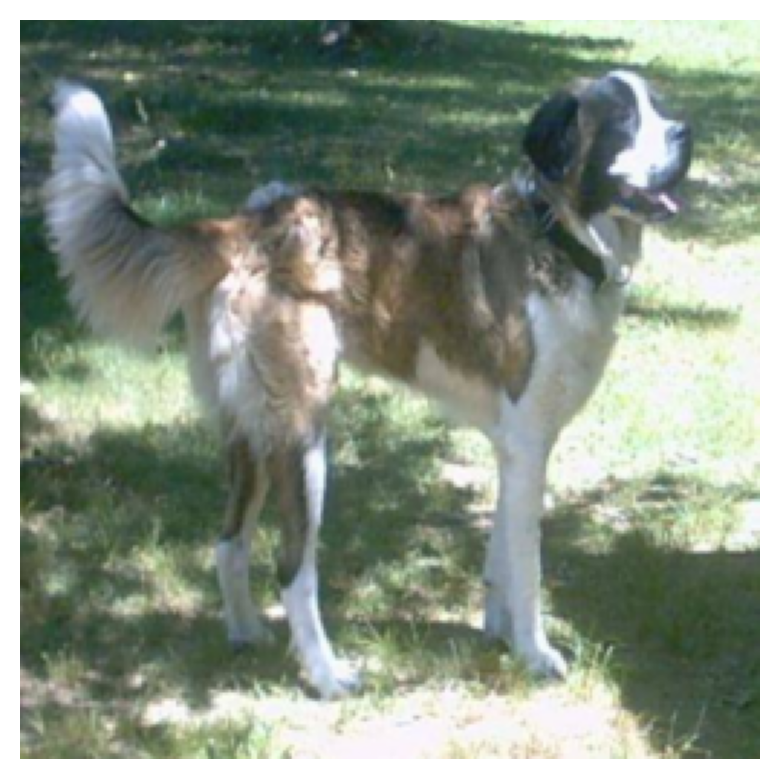

In [11]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation.
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```python
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



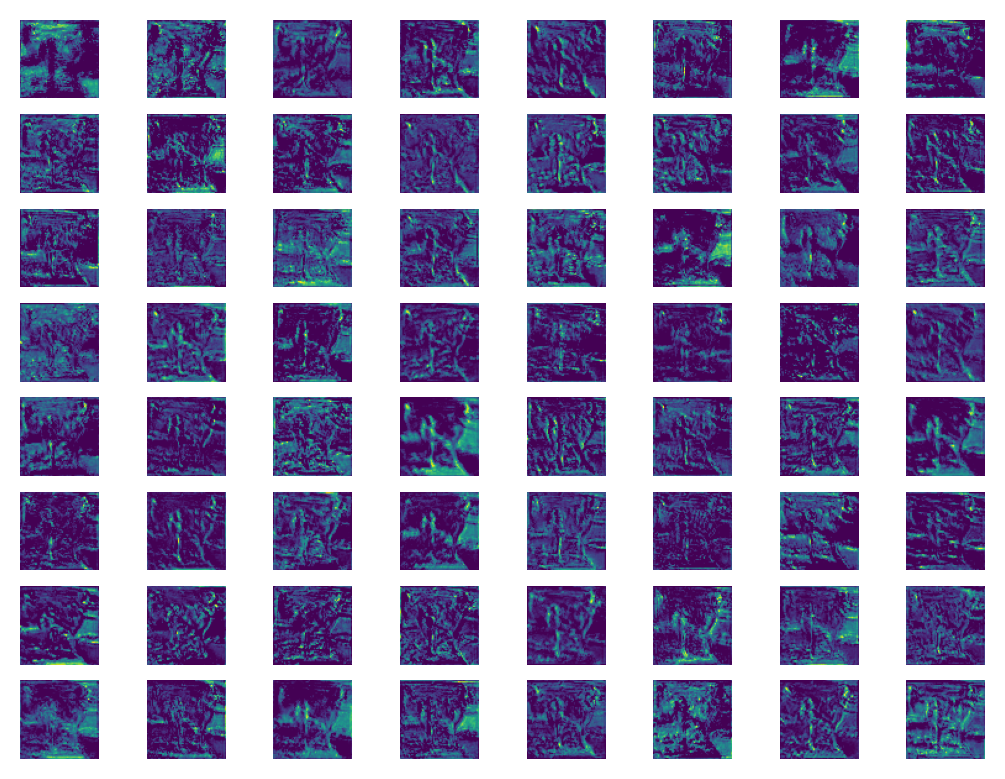

In [12]:
import math

def plot_intermediate_output(result, title):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert N * M >= n_filters

  fig, axs = plt.subplots(N, M)
  fig.suptitle(title)

  for i in range(N):
    for j in range(M):

      if i*N + j < n_filters:
        axs[i][j].imshow(result[0, i*N + j].cpu().detach())
        axs[i][j].axis('off')

# TODO:
# pick a few intermediate representations from your network and plot them using
# the provided function.


model.eval()

# take the first 4 top-level children as a feature extractor
feature_extractor = nn.Sequential(*list(model.children())[:4])

# add batch dim and move to device
img_batched = image.unsqueeze(0).to(device, non_blocking=True)

with torch.no_grad():
    feats = feature_extractor(img_batched)

plot_intermediate_output(feats, title=None)

What can you say about those filters? What features are they focusing on?

Anwer: These filters are capturing low-level visual patterns such as edges, color transitions, and simple textures. You can see activations highlighting boundaries, corners, and fine textures in different orientations and regions of the image. At this stage, the model is learning basic structural details—the building blocks (edges, gradients, and texture patterns) that later layers will combine into higher-level shapes and object features like fur, eyes, or background contours.